## Importing Data
Import Data and append to a single CSV file 

In [1]:

import pandas as pd  
import glob
import os
## data path 
import warnings
warnings.filterwarnings('ignore')
data_path=r"C:\Users\phili\Desktop\Mary\Robinss\Jobs\Vrtexa\vortexa"
os.chdir(data_path)
files=glob.glob('*.csv')

print(files)

## Append all the the station info 
f_OD = pd.concat([pd.read_csv(f) for f in glob.glob('OD*.csv')], ignore_index=True)
f_stations=pd.concat([pd.read_csv(f) for f in glob.glob('S*.csv')], ignore_index=True)

#Change start and end dates 
f_OD.start_date=pd.to_datetime(f_OD.start_date)
f_OD.end_date=pd.to_datetime(f_OD.end_date)

# change is_member to categories :
f_OD.is_member=f_OD.is_member.astype('category')
f_OD.start_station_code=f_OD.start_station_code.astype('category')
f_OD.end_station_code=f_OD.end_station_code.astype('category')

## Remove duplicates :

f_stations=f_stations.drop_duplicates('code',keep='first')

['OD_2014-04.csv', 'OD_2014-05.csv', 'OD_2014-06.csv', 'OD_2014-07.csv', 'OD_2014-08.csv', 'OD_2014-09.csv', 'OD_2014-10.csv', 'OD_2014-11.csv', 'OD_2015-04.csv', 'OD_2015-05.csv', 'OD_2015-06.csv', 'OD_2015-07.csv', 'OD_2015-08.csv', 'OD_2015-09.csv', 'OD_2015-10.csv', 'OD_2015-11.csv', 'OD_2016-04.csv', 'OD_2016-05.csv', 'OD_2016-06.csv', 'OD_2016-07.csv', 'OD_2016-08.csv', 'OD_2016-09.csv', 'OD_2016-10.csv', 'OD_2016-11.csv', 'OD_2017-04.csv', 'OD_2017-05.csv', 'OD_2017-06.csv', 'OD_2017-07.csv', 'OD_2017-08.csv', 'OD_2017-09.csv', 'OD_2017-10.csv', 'OD_2017-11.csv', 'Stations_2014.csv', 'Stations_2015.csv', 'Stations_2016.csv', 'Stations_2017.csv']


## Initial data wrangling 

* Convert certain categorical variables 
* Join on the code , to get latitude and longitude info 

In [2]:
## When to merge
f_stations.code=f_stations.code.astype('category')

Model_df=f_OD.merge(f_stations,left_on='start_station_code',right_on='code',how='inner')
Model_df_1=Model_df.merge(f_stations,left_on='end_station_code',right_on='code',how='inner')


Rename columns and drop unimportant ones

In [3]:
## Rename someof he columns 
Model_df_1.rename(columns={'latitude_x':'start_staion_latitude', 'longitude_x':'start_station_longitude','latitude_y':'end_station_latitude','longitude_y':'end_station_longitude'}, inplace=True)
Model_df_1['weekday'] = Model_df_1.start_date.dt.day_name()
Model_df_1['hour'] = Model_df_1.start_date.dt.hour
Model_df_1['month'] = Model_df_1.start_date.dt.month_name()
Model_df_1['daynum'] = Model_df_1.start_date.dt.dayofyear
Model_df_1=Model_df_1[['start_station_code','end_station_code','duration_sec','is_member','weekday','hour','month','start_staion_latitude','start_station_longitude','end_station_latitude','end_station_longitude']]


Resulting Data frame looks like :

In [20]:
  Model_df_1.head()


,start_station_code,end_station_code,duration_sec,is_member,weekday,hour,month,start_staion_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,6209,6436,1061,1,Tuesday,0,April,45.51252,-73.57062,45.486452,-73.595234
1,6209,6436,963,1,Sunday,1,April,45.51252,-73.57062,45.486452,-73.595234
2,6209,6436,953,1,Tuesday,14,May,45.51252,-73.57062,45.486452,-73.595234
3,6209,6436,1360,0,Friday,15,May,45.51252,-73.57062,45.486452,-73.595234
4,6209,6436,1010,0,Sunday,2,May,45.51252,-73.57062,45.486452,-73.595234


## Aggregation and Data Exploration 

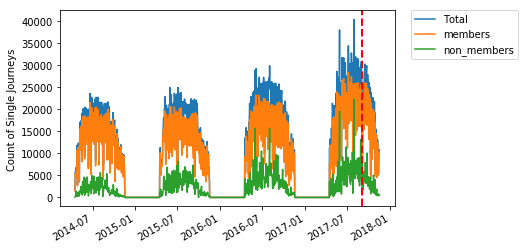

In [16]:
## A simple series plot by year to see where the current data relies  ::
#import matplotlib.pyplot as plt



def aggregate_journeys(df=f_OD,column_to_aggregate='start_date',daily_weekly_monthly='D'):

    ## group by day
    df.index=pd.to_datetime(df.start_date, unit='s')
    aggregated_day_journeys=df[column_to_aggregate].resample(daily_weekly_monthly, loffset=pd.Timedelta(1, 'd')).count()
    # For each year , no of journeys that took place across each month ?

    ## Plot the data changign for the 1st year :
    aggregated_day_journeys=pd.DataFrame(aggregated_day_journeys)
    #df_aggregated.iloc[:,0]
    aggregated_day_journeys.columns=['aggregated_count']
    return(aggregated_day_journeys)

aggregated_day_journeys=aggregate_journeys(df=f_OD,column_to_aggregate='start_date',daily_weekly_monthly='D')

# For members :


members_df=f_OD[f_OD.is_member==1]
non_members=f_OD[f_OD.is_member==0]
aggeregated_members=aggregate_journeys(df=members_df)
aggregated_non_member=aggregate_journeys(df=non_members)




def filter_date_(df=aggregated_day_journeys,start_date='2014-04-01',end_date='2015-04-01'):

    ## Check the aggregation per day for the 204-1

    mask=(df.index> start_date) & (df.index <= end_date)
    aggregated_year=df.loc[mask]

    
    return(aggregated_year)
   


## Plot the resultant time 
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot_date(aggregated_day_journeys.index, aggregated_day_journeys.aggregated_count, marker='', linestyle='-',label="Total")

plt.plot(aggeregated_members,label="members")
plt.plot(aggregated_non_member,label="non_members")
ax.axvline(pd.to_datetime('2017-09-01'), color='r', linestyle='--', lw=2)
ax.set_ylabel('Count of Single Journeys ')

## Members vs non members :
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.autofmt_xdate()
plt.show()



## Add a trend line 



Members consistenly make up the propotion of single journeys  across the years . We also see a linear increase in number of single jounreys 
by the members across the years . The red line represents end of data as specified in the instructions

### Now that we seen how years affect single journeys , look at a more granular level : How does week , day,month affect user journeys ?

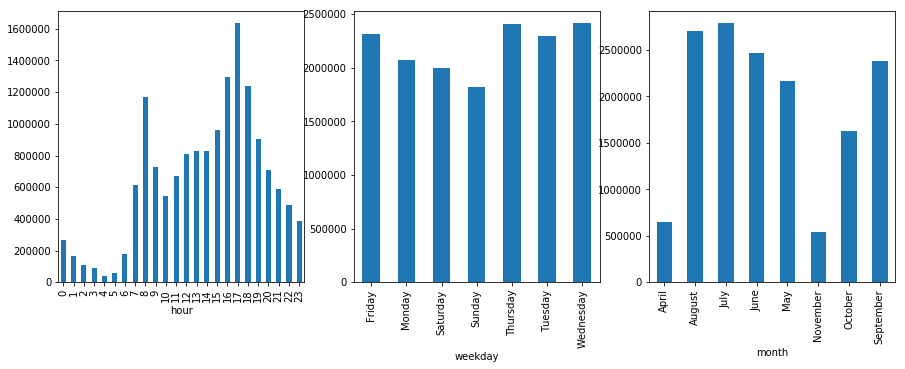

In [50]:

plt.figure(figsize=(15,5));
plt.subplot(1,3,2);
Model_df_1.groupby(['weekday']).size().plot(kind='bar', color='#1f77b4',)


plt.subplot(1,3,1);
Model_df_1.groupby('hour').size().plot(kind='bar', color='#1f77b4');

plt.subplot(1,3,3);
Model_df_1.groupby('month').size().plot(kind='bar', color='#1f77b4');

Insights :
* Maximum user journeys peak around evening time , following an approximate gaussian
* Bike rides across weekdays is fairly uniform
* Summer months attract more rides

## Exploring Variables :
Look at how memberships affects , journey counts for the specified rout 6184 to 601 route

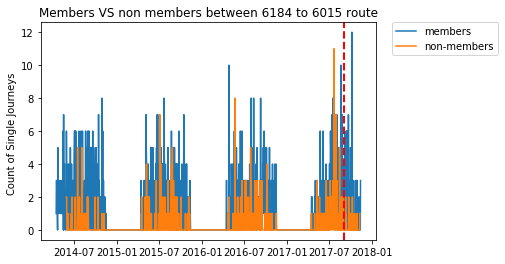

In [6]:
# Find trips jappening in the specified start and end loc
#6184 to 6015
## Filter stations for 

Intrested_journeys=f_OD[(f_OD.start_station_code==6184)&(f_OD.end_station_code==6015)]

Intrested_journeys_aggregated_daily=aggregate_journeys(df=Intrested_journeys)


Intrested_journeys_members_df=Intrested_journeys[Intrested_journeys.is_member==1]
Intrested_journeys_non_members=Intrested_journeys[Intrested_journeys.is_member==0]
Intrested_aggeregated_members=aggregate_journeys(df=Intrested_journeys_members_df)
Intrested_aggregated_non_member=aggregate_journeys(df=Intrested_journeys_non_members)

fig, ax = plt.subplots()

#plt.plot(Intrested_journeys_aggregated_daily.index,Intrested_journeys_aggregated_daily,label="total")
plt.plot(Intrested_aggeregated_members.index,Intrested_aggeregated_members,label="members")
plt.plot(Intrested_aggregated_non_member.index,Intrested_aggregated_non_member,label="non-members")

ax.axvline(pd.to_datetime('2017-09-01'), color='r', linestyle='--', lw=2)
ax.set_ylabel('Count of Single Journeys ')
#ax.title("Journeysmade from 6184 to 6015 ")
## Members vs non members :
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title("Members VS non members between 6184 to 6015 route")
plt.show()


## Aggregate it weekly :



As before user journeys are dominated my members with multimodal distributions across years.
However to make a daily forecast , see how the counts vary on a daily across memberships:

Text(0.5, 1.0, 'Route 6184 -6015  day trips')

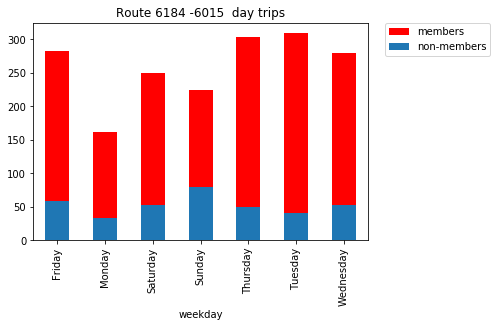

In [56]:

import numpy as np
## How does the Route we are inrested in 
# Daily which Route has the most number of trips ?
Intrested_journeys['weekday'] = Intrested_journeys.start_date.dt.day_name()
Intrested_journeys['hour'] = Intrested_journeys.start_date.dt.hour
Intrested_journeys['month'] = Intrested_journeys.start_date.dt.month_name()
Intrested_journeys['daynum'] = Intrested_journeys.start_date.dt.dayofyear
Intrested_journeys['year'] = Intrested_journeys.start_date.dt.year
Intrested_journeys['week'] = Intrested_journeys.start_date.dt.weekofyear
Intrested_journeys_members_df=Intrested_journeys[Intrested_journeys.is_member==1]
Intrested_journeys_non_members=Intrested_journeys[Intrested_journeys.is_member==0]

y_pos = np.arange(len(Intrested_journeys_members_df.index))
members_daily=pd.DataFrame(Intrested_journeys_members_df.groupby('weekday').size())
nonmembers_daily=pd.DataFrame(Intrested_journeys_non_members.groupby('weekday').size())
ax=members_daily.plot(kind="bar",color
                      ="red")
nonmembers_daily.plot(kind='bar',ax=ax)
L=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
L.get_texts()[0].set_text('members')
L.get_texts()[1].set_text('non-members')

plt.title("Route 6184 -6015  day trips")




## Modelling aggregated journeys : Transofrming the dataset 

In order to Forecast daily , data needs to be aggregdated on a daily basis , this would however mean we loose information on hourly info . Also discared the route information for now ,this assumnes spatial independence , however will be looking at data only for th specified route

In [52]:

## Create Count variables for Casual and registered memebers :
df_route_prediction=f_OD

## First define our training set:
df_route_prediction=filter_date_(df=Intrested_journeys,end_date="2017-08-31 23:59:59")
# For a a daily forecast : delete hourly prediction as aggregatign over it so drop


df_route_prediction=df_route_prediction.drop('hour',1)

## Drop unwanted variables :

df_route_prediction=df_route_prediction.drop(['start_station_code','end_station_code','start_date','end_date'],1)

new_column=df_route_prediction.groupby(['year','month','week','weekday','is_member']).resample('D').count()['duration_sec']
df_count=pd.DataFrame(new_column.reset_index())
df_count=df_count.rename(index=str, columns={"duration_sec": "count"})

Modelliing_df=pd.merge(aggregated_data,df_count)
Modelliing_df.week=Modelliing_df.week.astype('category')
Modelliing_df.weekday=Modelliing_df.weekday.astype('category')
Modelliing_df.month=Modelliing_df.month.astype('category')
Modelliing_df.year=Modelliing_df.year.astype('category')
Modelliing_df.is_member=Modelliing_df.is_member.astype('category')


In [53]:
Modelliing_df.head()

,year,month,week,weekday,is_member,duration_sec,start_date,count
0,2014,April,16,Friday,1,1642.000000,2014-04-18,2
1,2014,April,16,Saturday,1,461.000000,2014-04-19,1
2,2014,April,16,Sunday,1,733.000000,2014-04-20,1
3,2014,April,16,Thursday,1,461.666667,2014-04-17,3
4,2014,April,16,Tuesday,1,517.000000,2014-04-15,1


Look at if there is any correlation between the varialbles , specifically duration_sec and count
Starting with members first:

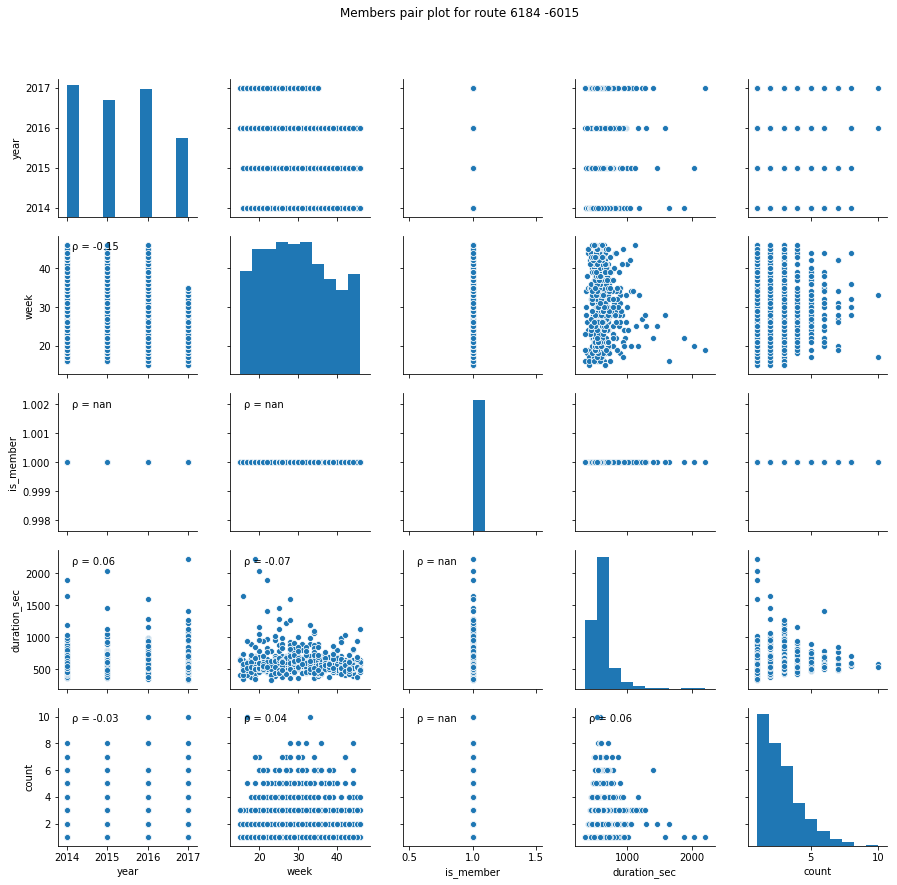

In [68]:
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(u"\u03C1 = {:.2f}".format(r), #unicode code for lowercase rho (ρ)
                xy=(.1, .9), xycoords=ax.transAxes)



g = sns.pairplot(Modelliing_df[Modelliing_df.is_member==1])
g.map_lower(corrfunc)
# Access the figure
fig = g.fig 


# Add a title to the Figure
fig.suptitle("Members pair plot for route 6184 -6015", fontsize=12)
plt.subplots_adjust(top=0.9)
plt.show()



Not accurate to use correlation measure for categorical variables : 
* Count varible highly skewed ( model using a poission regression ?)
* Very poorly correlated variables , regression unlikely to give any decent predictions
* Count -duration_sec poor correlation (0.06)  

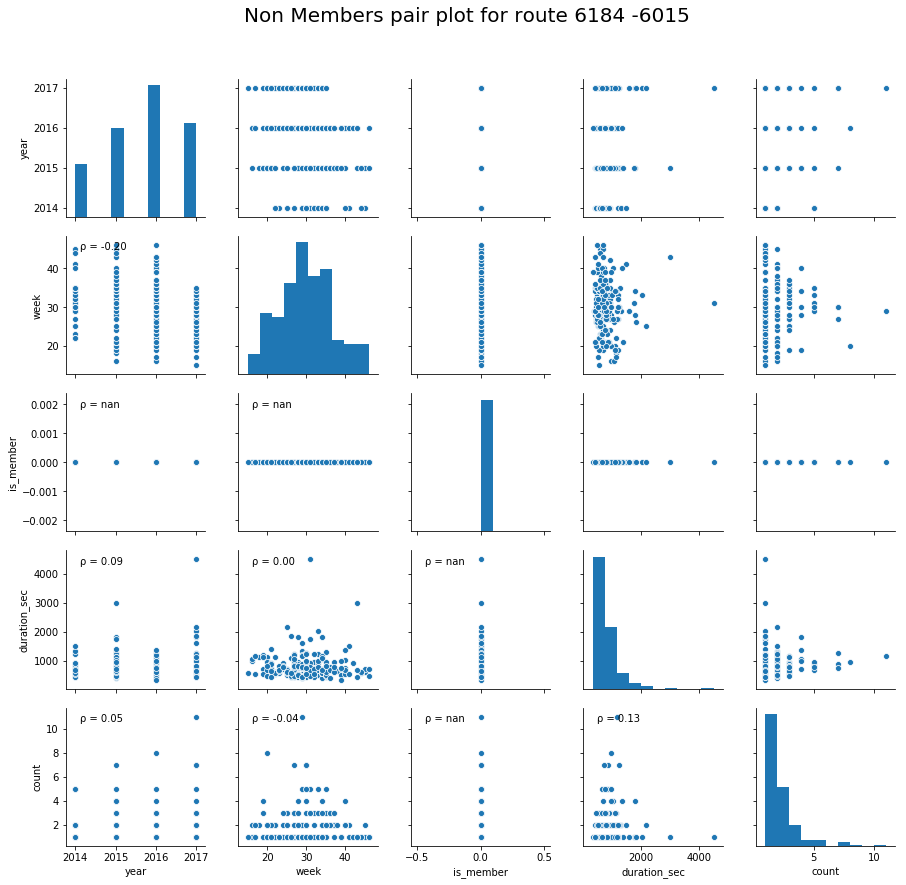

In [69]:
g = sns.pairplot(Modelliing_df[Modelliing_df.is_member==0])
g.map_lower(corrfunc)
# Access the figure
fig = g.fig 

# Add a title to the Figure
fig.suptitle("Non Members pair plot for route 6184 -6015", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

Not accurate to use correlation measure for categorical variables : 
* Count varible highly skewed ( model using a poission regression ?)
* Very poorly correlated variables , regression unlikely to give any decent predictions
* Count -duration_sec better correlation (0.13)  

# How does daily count   across years look like ?



[Text(0, 0, 'Friday'),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday')]

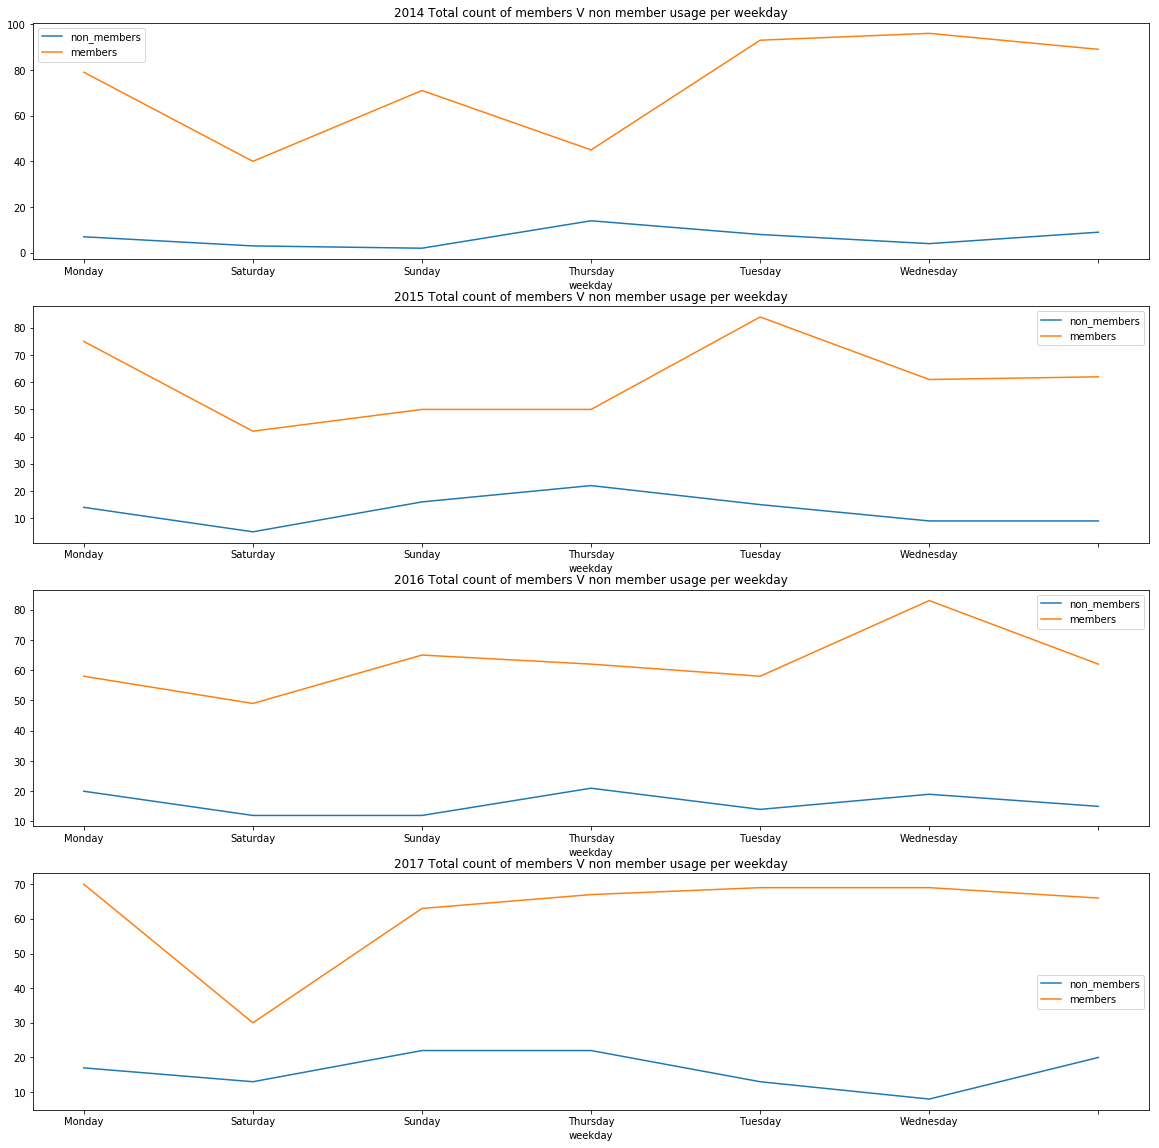

In [71]:
aggregaed_per_member=Intrested_journeys.groupby(['year','weekday','is_member']).resample('D').agg({'duration_sec':'mean','start_date':'count'})
aggregaed_per_member=aggregaed_per_member.drop(columns="duration_sec")
agg_per_year=aggregaed_per_member.groupby(['year','weekday','is_member',]).sum()
agg_per_year=agg_per_year.rename(columns={'start_date':'counts'})


f, a = plt.subplots(4,1)
ax=agg_per_year.unstack().xs(2014).plot(ax=a[0],figsize=(20,20),title="2014 Total count of members V non member usage per weekday")

ax.legend(["non_members", "members"]);
ax.set_xticklabels(agg_per_year.unstack().xs(2014).index)
ax=agg_per_year.unstack().xs(2015).plot(ax=a[1],figsize=(20,20),title="2015 Total count of members V non member usage per weekday")
ax.legend(["non_members", "members"]);
ax.set_xticklabels(agg_per_year.unstack().xs(2015).index)
ax=agg_per_year.unstack().xs(2016).plot(ax=a[2],figsize=(20,20),title="2016 Total count of members V non member usage per weekday")
ax.legend(["non_members", "members"]);
ax.set_xticklabels(agg_per_year.unstack().xs(2016).index)
ax=agg_per_year.unstack().xs(2017).plot(ax=a[3],figsize=(20,20),title="2017 Total count of members V non member usage per weekday")
ax.legend(["non_members", "members"]);
ax.set_xticklabels(agg_per_year.unstack().xs(2017).index)






## Buid a Random Forest  model modelling the counts 
Model on Categorical variables with start and end station code , look at the daily orecast